In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# define the ConvNet
class EpiNet:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        # CONV => RELU => POOL => DROPOUT
        model.add(Conv1D(50, kernel_size=5, padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=5, strides=1))
        model.add(Dropout(0.5))
        # Flatten => RELU layers
        model.add(Flatten())
        model.add(Dense(625))
        model.add(Activation('relu'))
        model.add(Dense(125))
        model.add(Activation('relu'))
        # a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        return model

In [3]:
# set parameters
NUM_EPOCH = 20
BATCH_SIZE = 512
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 2
INPUT_X = 'Ovary/ovary_bin_signal.npy'
INPUT_y = 'Ovary/ovary_gene_expr_binary_class.tsv'

In [4]:
# load data
X = np.load(INPUT_X)
y = np.genfromtxt(INPUT_y)

In [5]:
# remove the empty matrix
with_signal = []
for i in range(X.shape[0]):
    if X[i,:,:].max() > 0:
        with_signal.append(i)
        
X = X[with_signal,:,:]
y = y[with_signal]
print(X.shape)
print(y.shape)

INPUT_SHAPE = (X.shape[1], X.shape[2])

(51125, 7, 100)
(51125,)


In [6]:
# normalize matrix
for i in range(X.shape[0]):
    X[i,:,:] /= X[i,:,:].max()

In [7]:
# randomly split the dataset into training and test subset
np.random.seed(1234)
rand_idx = np.random.permutation(X.shape[0])
n = len(rand_idx) * 2/3
y_train, y_test = np.split(y[rand_idx], [n])
X_train, X_test = np.vsplit(X[rand_idx], [n])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(34083, 7, 100)
(34083,)
(17042, 7, 100)
(17042,)


In [8]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [9]:
# initialize the optimizer and model
model = EpiNet.build(input_shape=INPUT_SHAPE, classes=NUM_CLASSES)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7, 50)             25050     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 50)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 50)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 625)               94375     
_________________________________________________________________
activation_2 (Activation)    (None, 625)               0         
__________

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 27266 samples, validate on 6817 samples
Epoch 1/20
27266/27266 [==============================] - 1s - loss: 0.5271 - acc: 0.7326 - val_loss: 0.4565 - val_acc: 0.7921
Epoch 2/20
27266/27266 [==============================] - 1s - loss: 0.4524 - acc: 0.7865 - val_loss: 0.4353 - val_acc: 0.7955
Epoch 3/20
27266/27266 [==============================] - 1s - loss: 0.4347 - acc: 0.7954 - val_loss: 0.4319 - val_acc: 0.7998
Epoch 4/20
27266/27266 [==============================] - 1s - loss: 0.4251 - acc: 0.8013 - val_loss: 0.4307 - val_acc: 0.8005
Epoch 5/20
27266/27266 [==============================] - 1s - loss: 0.4184 - acc: 0.8052 - val_loss: 0.4405 - val_acc: 0.7905
Epoch 6/20
27266/27266 [==============================] - 1s - loss: 0.4164 - acc: 0.8054 - val_loss: 0.4380 - val_acc: 0.7974
Epoch 7/20
27266/27266 [==============================] - 1s - loss: 0.4043 - acc: 0.8122 - val_loss: 0.4369 - val_acc: 0.7984
Epoch 8/20
27266/27266 [==============================] - 1s -

In [12]:
score = model.evaluate(X_test, y_test)
print
print('Test accuracy:', score[1])

16512/17042 [============================>.] - ETA: 0s
('Test accuracy:', 0.78089426121595895)


In [13]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test[:,0], y_pred[:,0])
print('AUC:', metrics.auc(fpr, tpr))

('AUC:', 0.85752680752461763)


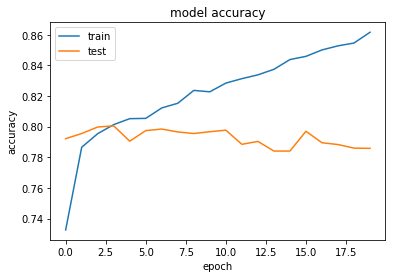

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
